In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd
import numpy as np

c:\Program Files\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv(r'C:\Users\sahus\Stress-Prediction\cluster_test.csv')

In [4]:
data = data.drop('Unnamed: 0', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451270 entries, 0 to 451269
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   EDA      451270 non-null  float64
 1   TEMP     451270 non-null  float64
 2   BVP      451270 non-null  float64
 3   HR       451270 non-null  float64
 4   Cluster  451270 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 17.2 MB


In [5]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X.shape, y.shape

((451270, 4), (451270,))

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451270 entries, 0 to 451269
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   EDA     451270 non-null  float64
 1   TEMP    451270 non-null  float64
 2   BVP     451270 non-null  float64
 3   HR      451270 non-null  float64
dtypes: float64(4)
memory usage: 13.8 MB


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=73)

In [8]:
X_train.shape, X_test.shape

((361016, 4), (90254, 4))

In [9]:
# splitting X_test again using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=73)

In [10]:
X_train.shape, X_test.shape

((67690, 4), (22564, 4))

In [11]:
y_train.shape, y_test.shape

((67690,), (22564,))

In [12]:
# %% convert to float32
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
X_train = X_train.values.astype(np.float32)
X_test = X_test.values.astype(np.float32)
y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

In [129]:
# %% dataset
class StressData(Dataset):
    def __init__(self, X_train, y_train) -> None:
        super().__init__()
        # Convert DataFrame to NumPy ndarray 
        X_train_np = X_train.astype(np.float32) 
        y_train_np = y_train.astype(np.int64) 
        # Convert NumPy ndarray to PyTorch tensor 
        self.X = torch.from_numpy(X_train_np) 
        self.y = torch.from_numpy(y_train_np)

        # self.X = torch.from_numpy(X_train)
        # self.y = torch.from_numpy(y_train)
        # self.y = self.y.type(torch.LongTensor)
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.len


In [130]:
# %% dataloader
stress_data = StressData(X_train=X_train, y_train=y_train)
train_loader = DataLoader(dataset=stress_data, batch_size=32)

In [131]:
# %% check dimensions
print(f"X Shape: {stress_data.X.shape}, y shape: {stress_data.y.shape}")


X Shape: torch.Size([67690, 4]), y shape: torch.Size([67690])


In [168]:
# %% define class
class MultiClassNet(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN_FEATURES):
        super().__init__()
        self.lin1 = nn.Linear(NUM_FEATURES, HIDDEN_FEATURES)
        self.lin2 = nn.Linear(HIDDEN_FEATURES, NUM_CLASSES)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.lin1(x)
        x = torch.sigmoid(x)
        x = self.lin2(x)
        x = self.sigmoid(x)
        return x

In [171]:
# %% hyper parameters
NUM_FEATURES = stress_data.X.shape[1]
HIDDEN = 8
NUM_CLASSES = len(stress_data.y.unique())

In [172]:
NUM_FEATURES, NUM_CLASSES

(4, 2)

In [173]:
# %% create model instance
model = MultiClassNet(NUM_FEATURES=NUM_FEATURES, NUM_CLASSES=NUM_CLASSES, HIDDEN_FEATURES=HIDDEN)

In [174]:
# %% loss function
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss() # binary cross entropy loss

In [175]:
# %% optimizer
lr = 0.02
optimizer=torch.optim.SGD(model.parameters(), lr=lr)

In [176]:
# %% training
NUM_EPOCHS = 50
losses = []
for epoch in range(NUM_EPOCHS):
    for x, y in train_loader:
      
        # initialize gradients
        optimizer.zero_grad()

        # forward pass
        y_hat_log = model(x)
        
        # calculate losses
        loss = criterion(y_hat_log, y)
        
        # calculate gradients
        
        loss.backward()
        # update parameters 
        optimizer.step()

    if (epoch % 10 == 0):
        print(f"Epoch {epoch}, Loss: {loss.data}")
        print(y_hat_log)
        
    losses.append(float(loss.data.detach().numpy()))

Epoch 0, Loss: 0.7067067623138428
tensor([[0.6420, 0.6989],
        [0.6317, 0.6563],
        [0.6203, 0.6649],
        [0.6420, 0.6989],
        [0.6420, 0.6989],
        [0.6420, 0.6989],
        [0.6419, 0.6987],
        [0.6416, 0.6980],
        [0.6195, 0.6589],
        [0.6420, 0.6989]], grad_fn=<SigmoidBackward0>)
Epoch 10, Loss: 0.7031141519546509
tensor([[0.8808, 0.0867],
        [0.3731, 0.6877],
        [0.8856, 0.1178],
        [0.2646, 0.8238],
        [0.8773, 0.0911],
        [0.2657, 0.8226],
        [0.4534, 0.6027],
        [0.2605, 0.8279],
        [0.8854, 0.1177],
        [0.3081, 0.7777]], grad_fn=<SigmoidBackward0>)
Epoch 20, Loss: 0.706459641456604
tensor([[0.9327, 0.0617],
        [0.3651, 0.7358],
        [0.9336, 0.0785],
        [0.2390, 0.8615],
        [0.9325, 0.0620],
        [0.2432, 0.8583],
        [0.4783, 0.6171],
        [0.2345, 0.8649],
        [0.9336, 0.0785],
        [0.3040, 0.8095]], grad_fn=<SigmoidBackward0>)
Epoch 30, Loss: 0.729778051376

<Axes: >

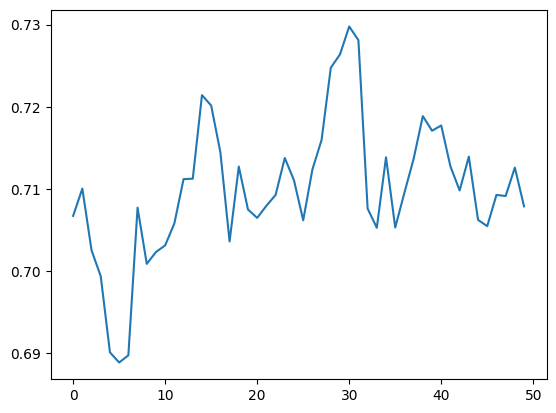

In [177]:
# %% show losses over epochs

sns.lineplot(x= range(len(losses)), y = losses)

In [162]:
# %% test the model
X_test_torch = torch.from_numpy(X_test)
with torch.no_grad():
    y_test_hat_softmax = model(X_test_torch)
    y_test_hat = torch.max(y_test_hat_softmax.data, 1)


In [163]:
# %% Accuracy
accuracy_score(y_test, y_test_hat.indices)

0.5075784435383797

In [164]:
from collections import Counter
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {most_common_cnt / len(y_test) * 100} %")


Naive Classifier: 50.75784435383797 %
